# Assignment Briefing
1) Dataset Description:

This dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels) for learning how to train fastText for sentiment analysis.

The idea here is a dataset is more than a toy - real business data on a reasonable scale - but can be trained in minutes on a modest laptop.


2) The Tasks:
    
- Download and import the training and testing data sets.
- Bonus points for extracting reviews and labels using regular expressions and named groups.
- Create a new feature, called ‘n_tokens’ that counts how many tokens(words) there are in a review. In other words, a feature for the length of a review.
- Create a new feature, called ‘language’, which detects what is the language of each review. So this feature will have a different value for each row (review) of the data.
- Transform each review into a numeric vector of tokens using a bag-of-words. Use can use the CountVectorizer module from sklearn but limit the maximum number of features to be 1000 to avoid memory issues (you can decrease it further if you still have memory issues). Explore the other parameters of the function as well.
- Using the fitted and transformed vector and the above created features, train a model that predicts the sentiment of a review. Note that this will be a classification problem. Evaluate your model and motivate your choice of a performance metric.(Hint: the feature for language is of type ‘object’, you may want to transform it to binary, such that it is 1 if the language is in English, 0 otherwise).

## Exploratory Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 # To open zipped files
import re # regular expressions
import os
import gc

import matplotlib.pyplot as plt # plotting
import seaborn as sns

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from langdetect import detect
import bz2
from sklearn.preprocessing import StandardScaler

We start with importing the .csv files into a dataframe


In [2]:
train_file = bz2.BZ2File("train.ft.txt.bz2")

test_file = bz2.BZ2File("test.ft.txt.bz2")

## Data Preparation and Cleaning

Each review with more than 100 words was imported and tokenized. Afterward, all of the tokens that were punctuations, label, stopword, or not an English word (emoji, special character, foreign languages) were removed.

The remaining tokens would undergo the process of lemmatizing using WordNetLemmatizer to reduce word to its root form, and Lemmatization using Wordnet Lemmatizer to acquire primal terms before appending into a clean list.


Following are the process followed:

- Lowercasing
- Tokenization
- Stemming and Lemmatization
- Removing Stopwords
- Removing Punctuations
- Removing Digits
- Removing Url’s

### Convert from raw binary strings to strings that can be parsed

In [3]:
train_file_lines = [x.decode('utf-8') for x in train_file.readlines(size=1000000)]
test_file_lines = [x.decode('utf-8') for x in test_file.readlines(size=1000000)]

In [4]:
print(type(train_file_lines), type(test_file_lines), "\n")

print("Train Data Volume:", len(train_file_lines), "\n")
print("Test Data Volume:", len(test_file_lines), "\n\n")

print("Demo: ", "\n")
for x in train_file_lines[:2]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 2236 

Test Data Volume: 2217 


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this i

In [5]:
#Split the train dataset into two: sentiment and review

sentiment = [review.split("__label__")[1][0] for review in train_file_lines]
reviews = [review.split("__label__")[1][1:] for review in train_file_lines]
newlist = []

for i in range(len(sentiment)):
        newlist.append([sentiment[i], reviews[i]])

df = pd.DataFrame(newlist, columns = ['score', 'review'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   2236 non-null   object
 1   review  2236 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB


In [7]:
df['score'].value_counts()

1    1164
2    1072
Name: score, dtype: int64

In [8]:
n_tokens = lambda x : len(re.findall(r'\w+', x))
df['n_tokens'] = df['review'].apply(n_tokens)

In [9]:
df['language'] = df['review'].apply(detect)
df['language'] = df['language'].apply(lambda x: 1 if x == 'en' else 0)
df['language'].value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
2231    1
2232    1
2233    1
2234    1
2235    1
Name: language, Length: 2236, dtype: int64>

In [10]:
df.head()

,score,review,n_tokens,language
0,2,Stuning even for the non-gamer: This sound tr...,81,1
1,2,The best soundtrack ever to anything.: I'm re...,102,1
2,2,Amazing!: This soundtrack is my favorite musi...,136,1
3,2,Excellent Soundtrack: I truly like this sound...,122,1
4,2,"Remember, Pull Your Jaw Off The Floor After H...",90,1


### Extracting Labels from the data
`0 -> __label__1 -> 1/2 star rating`  
`1 -> __label__2 -> 4/5 star rating`

In [11]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

In [12]:
train_labels[0]

1

C:\Users\ams-duongn.EXPEDITORS\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train Labels distribution')

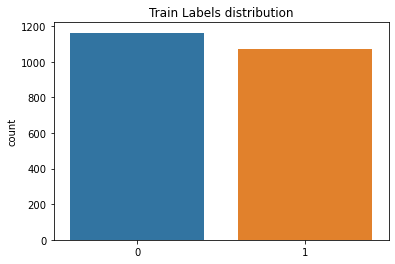

In [13]:
sns.countplot(train_labels)
plt.title('Train Labels distribution')

C:\Users\ams-duongn.EXPEDITORS\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test Labels distribution')

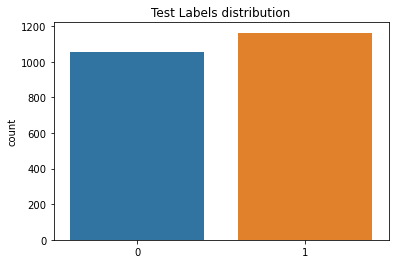

In [14]:
sns.countplot(test_labels)
plt.title('Test Labels distribution')

### Extracting Reviews from the data
clean newline character

In [15]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in train_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1] for x in test_file_lines]

In [16]:
train_sentences[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

#### Let’s count number of words in reviews and see it distribution

C:\Users\ams-duongn.EXPEDITORS\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

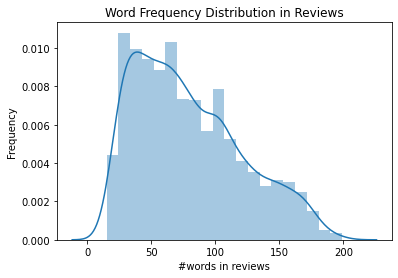

In [17]:
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))

sns.distplot(train_sentences_size)
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

In [18]:
train_label_len = pd.DataFrame({"labels": train_labels, "len": train_sentences_size})
train_label_len.head()

,labels,len
0,1,80
1,1,97
2,1,129
3,1,118
4,1,87


Now we’ll divide it by sentiment and calculate average values

Negative mean length: 82.30
Positive mean length: 75.75
Mean Difference: 6.55


Text(0.5, 1.0, 'Review Size Categorization')

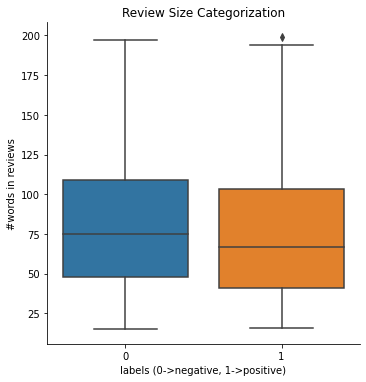

In [19]:
neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

In [20]:
del neg_mean_len,pos_mean_len
gc.collect()

15

### Clean URLs
mask url in data with `<url>`

In [21]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [22]:
list(filter(lambda x: '<url>' in x, train_sentences))[0]

"Bad Deal!!: I ordered this DVD and received a substitute I never received the DVD I ordered from Importcds (the Vendor). I contacted them and did not recieve any feedback. I can't rate a DVD I have never seen. I didn't bother to send it back because it would have cost me more that I orginally paid for it. In the future I will watch for the name of the person and/or persons I am buying from. I thought they were a good company. I understand a simple mistake but, to not get a response at all is not good businees sense. I spend hundreds of dollars a month on <url> building my DVD collection. I guess I will be more careful in the future."

In [23]:
del train_file_lines, test_file_lines
gc.collect()

45

## Lowercasing
The CAPS in the texts are RATHER irritating although we KNOW the guy is trying to EMPHASIZE on something.

We can simply lowercase them after we do sent_tokenize() and word_tokenize().
The tokenizers uses the capitalization as cues to know when to split so removing them before the calling the functions would be sub-optimal.


## Tokenization

- **Sentence tokenization** is the process of splitting up strings into “sentences”
- **Word tokenization** is the process of splitting up “sentences” into “words”


## Stemming and Lemmatization

Often we want to map the different forms of the same word to the same root word, e.g. "walks", "walking", "walked" should all be the same as "walk".

The stemming and lemmatization process are hand-written regex rules written find the root word.

- **Stemming:** Trying to shorten a word with simple regex rules
- **Lemmatization:** Trying to find the root word with linguistics rules (with the use of regexes)

(See also: Stemmers vs Lemmatizers question on StackOverflow - https://stackoverflow.com/q/17317418/610569)

### There are various stemmers and one lemmatizer in NLTK, the most common being:

- Porter Stemmer
- Wordnet Lemmatizer (Used in our Analysis)

*Note: Lemmatization won't really work on single words alone without context or knowledge of its POS tag (i.e. we need to know whether the word is a noun, verb, adjective, adverb) (https://www.kaggle.com/alvations/basic-nlp-with-nltk). By default, if you don't specify the part of speech, then all words are considered as nouns.*

In [24]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('averaged_perceptron_tagger')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is WALKING walking to school')

[nltk_data] Downloading package punkt to C:\Users\ams-
[nltk_data]     duongn.EXPEDITORS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ams-
[nltk_data]     duongn.EXPEDITORS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ams-
[nltk_data]     duongn.EXPEDITORS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['he', 'be', 'walking', 'walk', 'to', 'school']

## Stopwords

Stopwords are non-content words that primarily has only grammatical function. Often we want to remove stopwords when we want to keep the "gist" of the document/sentence.

## Using a stronger/longer list of stopwords

After applying NLTK Stopwords we have still dangly model verbs (i.e. 'could', 'wont', etc.).

We can combine the stopwords we have in NLTK with other stopwords list we find online.

Personally, I like to use stopword-json because it has stopwrds in 50 languages  
https://github.com/6/stopwords-json


## Punctuations
Often, we want to remove the punctuations from the documents too.  
Since Python comes with "batteries included", we have string.punctuation

In [25]:
# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

## Clean Digits

In [26]:
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [27]:
train_sentences[10]

"The Worst!: A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."

In [28]:
preprocess_text(train_sentences[10])

['bad',
 'complete',
 'waste',
 'time',
 'typographical',
 'error',
 'poor',
 'grammar',
 'totally',
 'pathetic',
 'plot',
 'add',
 'absolutely',
 "'m",
 'embarrassed',
 'author',
 'disappointed',
 'pay',
 'book']

## Word Embeddings

#### From Strings to Vectors

Vector is an array of numbers

- **Vector Space Model:** conceptualizing language as a whole lot of numbers

- **Bag-of-Words (BoW):** Counting each document/sentence as a vector of numbers, with each number representing the count of a word in the corpus


Vector space model or term vector model is an algebraic model for representing text documents as vectors of identifiers, for example, index terms. It is used in information filtering, information retrieval, indexing and relevancy rankings.


#### We are using sklearn CountVectorizer to create Vector Space Model

## Vectorization with sklearn

In scikit-learn, there're pre-built functions to do the preprocessing and vectorization.  

It will be the object that contains the vocabulary (i.e. the first row of our table above) and has the function to convert any sentence into the counts vectors.  

The input that CountVectorizer is a textfile/Iterable of strings

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [30]:
train_set = count_vect.fit_transform(train_sentences[:10000])

In [31]:
train_set.toarray().shape

(2236, 12204)

In [32]:
test_set = count_vect.transform(test_sentences[:1000])

<AxesSubplot:title={'center':'Most Frequent Words'}, xlabel='word'>

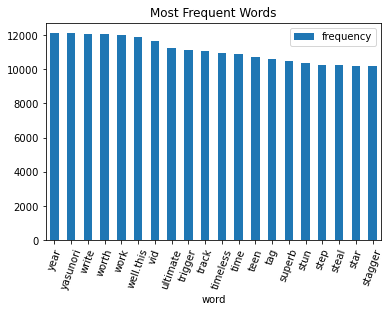

In [33]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")


## Multinomial Naive Bayes classifier in sklearn

### Naive Bayes Classification

In statistics, Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

Sources: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

There are different variants of Naive Bayes (NB) classifier in sklearn. For example, the MultinomialNB algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). Or the ComplementNB, which is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets.

**Multinomial** is a big word but it just means many classes/categories/bins/boxes that needs to be classified.

In [34]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [35]:
clf.fit(train_set, train_labels[:10000])

MultinomialNB()

In [36]:
from sklearn import metrics

# To predict our tags (i.e. whether requesters get their pizza), 
# we feed the vectorized `test_set` to .predict()
predictions_valid = clf.predict(test_set)

print("Confusion Matrix\n", metrics.confusion_matrix(test_labels[:1000], predictions_valid))
print("\n")
print("Classification Report\n", metrics.classification_report(test_labels[:1000], predictions_valid))
print("\n")
print('Amazon Sentiment Analysis Accuracy = {}'.format(
        metrics.accuracy_score(test_labels[:1000], predictions_valid) * 100)
     )

Confusion Matrix
 [[433  65]
 [147 355]]


Classification Report
               precision    recall  f1-score   support

           0       0.75      0.87      0.80       498
           1       0.85      0.71      0.77       502

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000



Amazon Sentiment Analysis Accuracy = 78.8


## Feature Importance

In [37]:
def important_features(vectorizer,classifier,n=40):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    class1_frequency_dict = {}
    class2_frequency_dict = {}
    
    for coef, feat in topn_class1:
        class1_frequency_dict.update( {feat : coef} )

    for coef, feat in topn_class2:
        class2_frequency_dict.update( {feat : coef} )

    return (class1_frequency_dict, class2_frequency_dict)

In [38]:
neg_frequency_dict, pos_frequency_dict = important_features(count_vect, clf)

In [39]:
neg_feature_freq = pd.DataFrame(neg_frequency_dict.items(), columns = ["feature_word", "frequency"])  
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"])  

<AxesSubplot:title={'center':'Important Negative Features(words)'}, xlabel='feature_word'>

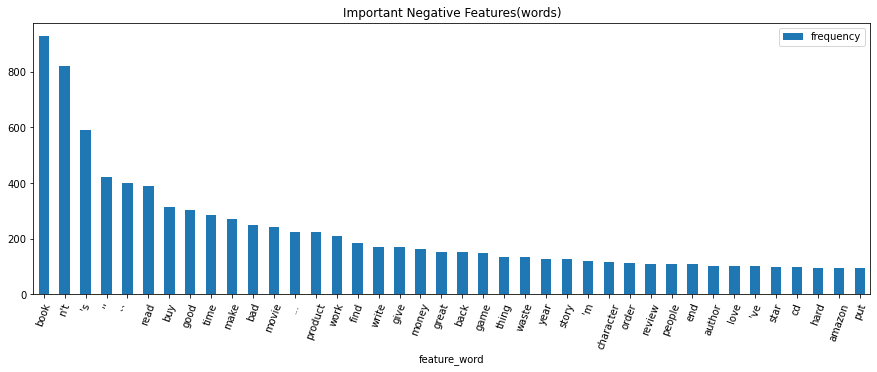

In [40]:
neg_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Negative Features(words)")

<AxesSubplot:title={'center':'Important Positive Features(words)'}, xlabel='feature_word'>

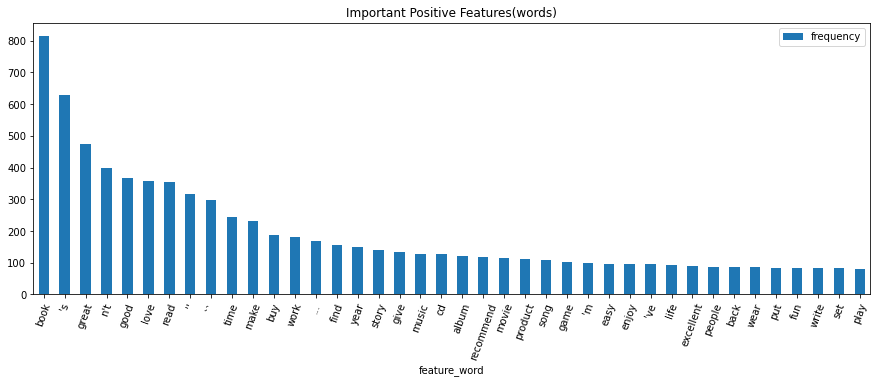

In [41]:
pos_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Positive Features(words)")

## Prediction Model Evaluation

- The objective of this prediction model is to leverage 4 Million unstructured product reviews containing various typos, nonstandard spellings, and other variations, to better understand customer sentiment regarding ecommerce products. Leveraging NLTK for data cleaning, matplotlib for plotting statistics, and scikit learn to predict consumer sentiment. With limitation in computational power, we extract only the first 1 million lines of reviews from the train dataset for training and we achieved an accuracy of 78,8%. We also investigated the most frequently occured words per Positive and Negative Sentiment category in the Feature Importance section.

- These insights from the analysis and prediction model will be valuable in better understanding consumer behaviour and reviews regarding Amazon products, and will directly impact including (not exhaustive): Amazon sellers and Academic Researchers.

- In business sense, we would like to limit the False Negative results from the Prediction since it is better to response to not-correctly prediction classified as Negative reviews, than to miss the opportunity to rectify the truely negative reviews but the model classified it as Positive. From this light, the model we build here is quite robust with good results from the Classification report and Confusion Matrix. Nevertheless, we still need to take into consideration of the following model limitations.

## Model Limitations

- Model is trained on the Amazon Product Review data, and does not assure guarantee of predicting correct label (positive or negative)for other e-commerce websites.

- The knowledge of categories of products are unknown, so we cannot generalize that the accuracy achieved by this model will be applicable to all product category segments.

- The predictions are always limitied to efficiency of:
    - Data Cleaning Algorithms
    - Text Embedding Algorithms
    - Prediction Algorithm